In [ ]:
!pip install 'contractions'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.0 MB/s eta 0:00:00


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, Bidirectional, GRU, BatchNormalization, Dropout
import matplotlib.pyplot as plt
import string
import re
import contractions

In [ ]:
imdb, info = tfds.load('imdb_reviews', with_info = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKAFX4Y/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKAFX4Y/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKAFX4Y/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
imdb

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('unsupervised'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [ ]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path=PosixGPath('/tmp/tmpb4q8e4sftfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInf

In [ ]:
train_data, test_data = imdb['train'], imdb['test']


In [ ]:
train_sentence = []
test_setences = []

train_labels = []
test_labels = []

for s, l in train_data:
  train_sentence.append(str(s.numpy()))
  train_labels.append(l.numpy())


for s,l in test_data:
  test_setences.append(str(s.numpy()))
  test_labels.append(l.numpy())


In [ ]:
def clean_data(text):
  text = text.replace("\\\\\\", ' ' )
  text = text.replace('\\xc2\\x96', " ")
  text = text.replace('\\xc3\\xa9d', " ")
  text = text.replace('<br /><br />', " ")
  text = text.replace('<br /><br />', " ")
  text = text.replace( "\\", " ")
  text = text.replace( "b", " ")
  text = contractions.fix(text)
  text = text.lower()
  punc_number = string.punctuation
  for c in punc_number:
    text = text.replace(c, ' ')

  return ' '.join(text.split())

In [ ]:
clean_data(train_sentence[0])

'this was an a solutely terri le movie do not e lured in y christopher walken or michael ironside both are great actors ut this must simply e their worst role in history even their great acting could not redeem this movie s ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the colum ian re els were making their cases for revolutions maria conchita alonso appeared phony and her pseudo love affair with walken was nothing ut a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor s like christopher walken s good name i could arely sit through it'

In [ ]:
train_sentence = [clean_data(text) for text in train_sentence]
test_setences = [clean_data(text) for text in test_setences]

In [ ]:
train_sentence

['this was an a solutely terri le movie do not e lured in y christopher walken or michael ironside both are great actors ut this must simply e their worst role in history even their great acting could not redeem this movie s ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the colum ian re els were making their cases for revolutions maria conchita alonso appeared phony and her pseudo love affair with walken was nothing ut a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor s like christopher walken s good name i could arely sit through it',
 'i have een known to fall asleep during films ut this is usually due to a com ination of things including really tired eing warm and comforta le on the sette and having just eaten a lot however on this occasion i fell asleep ecause the film was ru ish the plot development was constant constantly slow 

In [ ]:
vocab_size = 10000
embedding_dim = 300
max_len = 100
hidden_size = 256

In [ ]:
tokenizer = Tokenizer(num_words= vocab_size, oov_token = "<OOV>")
tokenizer.fit_on_texts(train_sentence)

In [ ]:
train_sequences  = tokenizer.texts_to_sequences(train_sentence)
test_sequences = tokenizer.texts_to_sequences(test_setences)

In [ ]:
train_padded_sequences = pad_sequences(train_sequences, maxlen = max_len,
                                       truncating = 'post', padding = 'post')

test_padded_sequences  = pad_sequences(test_sequences, maxlen = max_len,
                                       truncating = 'post', padding = 'post')

In [ ]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
simple_rnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length =max_len),
    SimpleRNN(hidden_size),
    Dense(1, activation = 'sigmoid')
])

simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          3000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               142592    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 3,142,849
Trainable params: 3,142,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
simple_rnn.compile(loss = "binary_crossentropy",
                   optimizer = 'adam',
                   metrics = ['accuracy'])

history_simple_rnn = simple_rnn.fit(train_padded_sequences, train_labels, validation_data = (test_padded_sequences, test_labels), epochs = 10)

Epoch 1/10
782/782 [==============================] - 145s 176ms/step - loss: 0.7058 - accuracy: 0.4990 - val_loss: 0.6963 - val_accuracy: 0.5076
Epoch 2/10
782/782 [==============================] - 101s 130ms/step - loss: 0.6959 - accuracy: 0.5120 - val_loss: 0.6944 - val_accuracy: 0.5122
Epoch 3/10
782/782 [==============================] - 107s 137ms/step - loss: 0.6782 - accuracy: 0.5647 - val_loss: 0.6947 - val_accuracy: 0.5350
Epoch 4/10
782/782 [==============================] - 95s 122ms/step - loss: 0.6389 - accuracy: 0.6174 - val_loss: 0.7180 - val_accuracy: 0.5280
Epoch 5/10
782/782 [==============================] - 120s 154ms/step - loss: 0.6014 - accuracy: 0.6614 - val_loss: 0.7132 - val_accuracy: 0.6024
Epoch 6/10
782/782 [==============================] - 99s 127ms/step - loss: 0.5684 - accuracy: 0.6979 - val_loss: 0.6857 - val_accuracy: 0.6486
Epoch 7/10
782/782 [==============================] - 96s 123ms/step - loss: 0.5181 - accuracy: 0.7469 - val_loss: 0.7544 - va

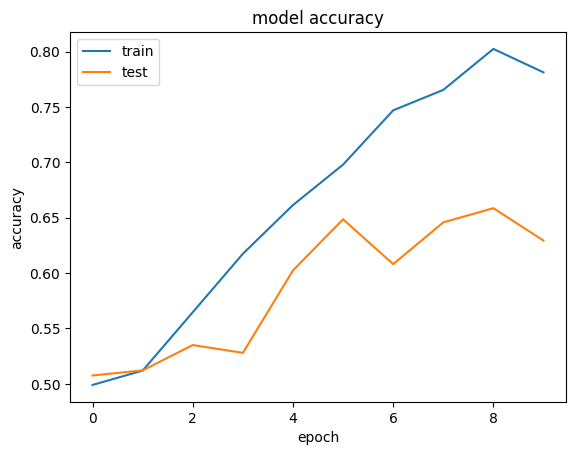

In [ ]:
plt.plot(history_simple_rnn.history['accuracy'])
plt.plot(history_simple_rnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

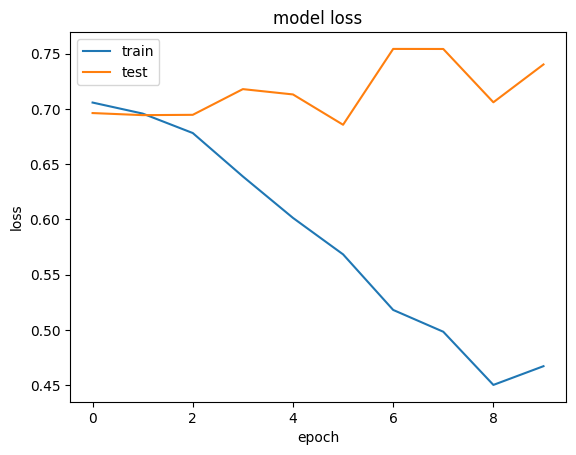

In [ ]:
plt.plot(history_simple_rnn.history['loss'])
plt.plot(history_simple_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
checkpoint_path = "./save_mode/Bidrect_rnn.ckpt"
cp_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = True,
    verbose=1
)

In [ ]:
Bidrect_rnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length =max_len),
    SimpleRNN(hidden_size, return_sequences = True),
    Bidirectional(SimpleRNN(hidden_size)),
    Dense(1, activation = 'sigmoid')
])

Bidrect_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          3000000   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100, 256)          142592    
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              262656    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 3,405,761
Trainable params: 3,405,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Bidrect_rnn.compile(loss = 'binary_crossentropy',
                         optimizer = 'adam',
                         metrics = ['acc'])

history_Bidrect_rnn = Bidrect_rnn.fit(train_padded_sequences, train_labels,
                          validation_data = (test_padded_sequences, test_labels), epochs = 10,
                                      batch_size = 256, callbacks = [cp_callback])

Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 0.7255 - acc: 0.5129
Epoch 1: saving model to ./save_mode/Bidrect_rnn.ckpt
98/98 [==============================] - 61s 584ms/step - loss: 0.7255 - acc: 0.5129 - val_loss: 0.6919 - val_acc: 0.5341
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 0.6470 - acc: 0.6201
Epoch 2: saving model to ./save_mode/Bidrect_rnn.ckpt
98/98 [==============================] - 48s 488ms/step - loss: 0.6470 - acc: 0.6201 - val_loss: 0.6398 - val_acc: 0.6382
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.5782 - acc: 0.6844
Epoch 3: saving model to ./save_mode/Bidrect_rnn.ckpt
98/98 [==============================] - 41s 418ms/step - loss: 0.5782 - acc: 0.6844 - val_loss: 0.6849 - val_acc: 0.6108
Epoch 4/10
98/98 [==============================] - ETA: 0s - loss: 0.5106 - acc: 0.7367
Epoch 4: saving model to ./save_mode/Bidrect_rnn.ckpt
98/98 [==============================] - 42s 434ms/step - loss

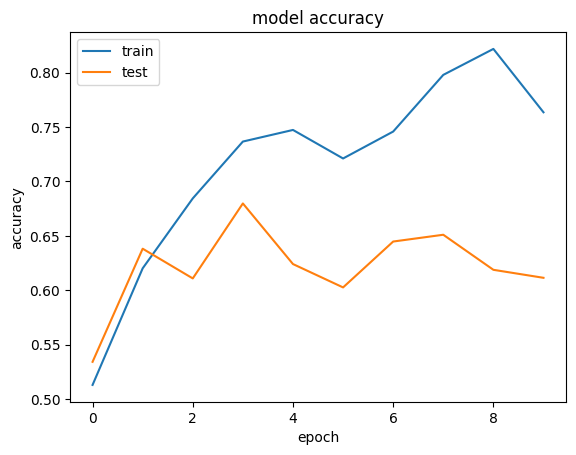

In [ ]:
plt.plot(history_Bidrect_rnn.history['acc'])
plt.plot(history_Bidrect_rnn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

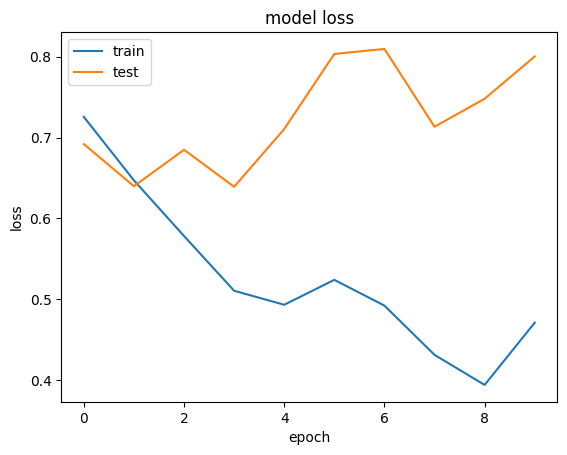

In [ ]:
plt.plot(history_Bidrect_rnn.history['loss'])
plt.plot(history_Bidrect_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import save_model

In [ ]:
Lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length =max_len),
    LSTM(hidden_size),
    Dense(1, activation = 'sigmoid')
])
Lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          3000000   
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,570,625
Trainable params: 3,570,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Lstm_model.compile(loss = 'binary_crossentropy',
                         optimizer = 'adam',
                         metrics = ['acc'])

save_model(Lstm_model, './save_mode/Lstm_model.h5')
history_Lstm_model = Bidrect_rnn.fit(train_padded_sequences, train_labels,
                          validation_data = (test_padded_sequences, test_labels), epochs = 10, batch_size = 256)

Epoch 1/10
98/98 [==============================] - 38s 386ms/step - loss: 0.4410 - acc: 0.7728 - val_loss: 0.7187 - val_acc: 0.6724
Epoch 2/10
98/98 [==============================] - 34s 348ms/step - loss: 0.3338 - acc: 0.8573 - val_loss: 0.7305 - val_acc: 0.7142
Epoch 3/10
98/98 [==============================] - 39s 395ms/step - loss: 0.3190 - acc: 0.8667 - val_loss: 0.7288 - val_acc: 0.7000
Epoch 4/10
98/98 [==============================] - 38s 391ms/step - loss: 0.3383 - acc: 0.8584 - val_loss: 0.8193 - val_acc: 0.7137
Epoch 5/10
98/98 [==============================] - 36s 368ms/step - loss: 0.2935 - acc: 0.8814 - val_loss: 0.7862 - val_acc: 0.6871
Epoch 6/10
98/98 [==============================] - 37s 371ms/step - loss: 0.2218 - acc: 0.9153 - val_loss: 0.7499 - val_acc: 0.7252
Epoch 7/10
98/98 [==============================] - 39s 398ms/step - loss: 0.2373 - acc: 0.9090 - val_loss: 0.7596 - val_acc: 0.6394
Epoch 8/10
98/98 [==============================] - 40s 410ms/step - 

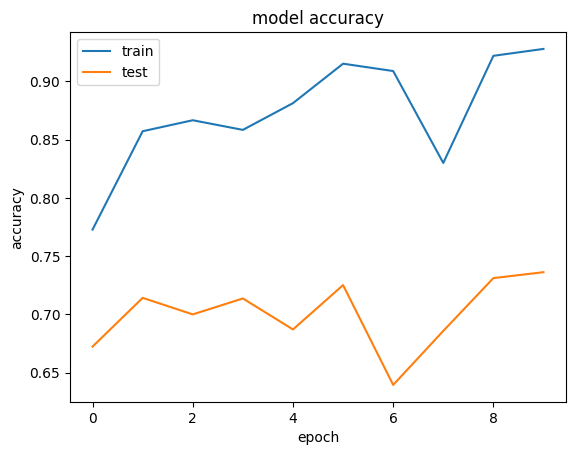

In [ ]:
plt.plot(history_Lstm_model.history['acc'])
plt.plot(history_Lstm_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

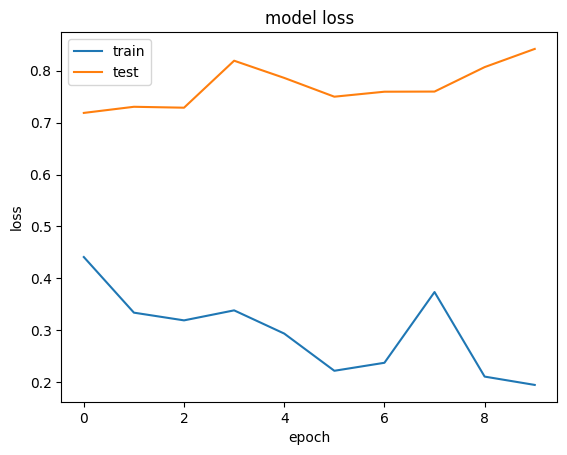

In [ ]:
plt.plot(history_Lstm_model.history['loss'])
plt.plot(history_Lstm_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
BiLstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length =max_len),
    LSTM(hidden_size, return_sequences = True),
    Bidirectional(LSTM(hidden_size)),
    Dense(1, activation = 'sigmoid')
])
BiLstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          3000000   
                                                                 
 lstm_1 (LSTM)               (None, 100, 256)          570368    
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,621,505
Trainable params: 4,621,505
Non-trainable params: 0
_________________________________________________________________


In [ ]:
BiLstm_model.compile(loss = 'binary_crossentropy',
                         optimizer = 'adam',
                         metrics = ['acc'])

save_model(BiLstm_model, './save_mode/BiLstm_model.h5')
history_BiLstm_model = BiLstm_model.fit(train_padded_sequences, train_labels,
                          validation_data = (test_padded_sequences, test_labels), epochs = 10, batch_size = 256)

Epoch 1/10
98/98 [==============================] - 32s 261ms/step - loss: 0.4881 - acc: 0.7557 - val_loss: 0.4667 - val_acc: 0.8016
Epoch 2/10
98/98 [==============================] - 23s 240ms/step - loss: 0.3139 - acc: 0.8715 - val_loss: 0.4175 - val_acc: 0.8092
Epoch 3/10
98/98 [==============================] - 17s 171ms/step - loss: 0.2455 - acc: 0.9062 - val_loss: 0.4761 - val_acc: 0.7975
Epoch 4/10
98/98 [==============================] - 18s 181ms/step - loss: 0.1883 - acc: 0.9298 - val_loss: 0.5738 - val_acc: 0.7931
Epoch 5/10
98/98 [==============================] - 15s 155ms/step - loss: 0.1187 - acc: 0.9582 - val_loss: 0.7233 - val_acc: 0.7866
Epoch 6/10
98/98 [==============================] - 17s 172ms/step - loss: 0.0794 - acc: 0.9725 - val_loss: 0.7619 - val_acc: 0.7805
Epoch 7/10
98/98 [==============================] - 14s 146ms/step - loss: 0.0671 - acc: 0.9759 - val_loss: 0.7671 - val_acc: 0.7674
Epoch 8/10
98/98 [==============================] - 17s 171ms/step - 

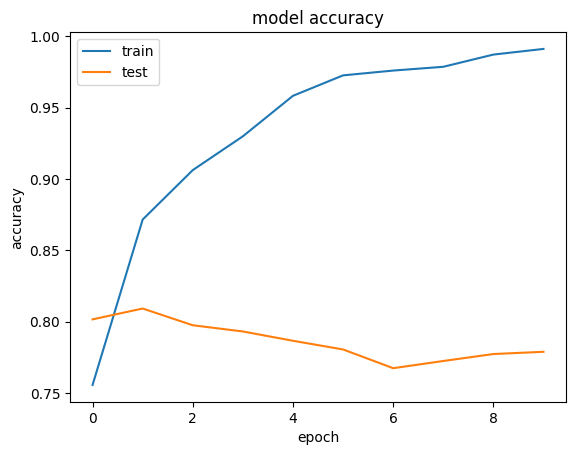

In [ ]:
plt.plot(history_BiLstm_model.history['acc'])
plt.plot(history_BiLstm_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

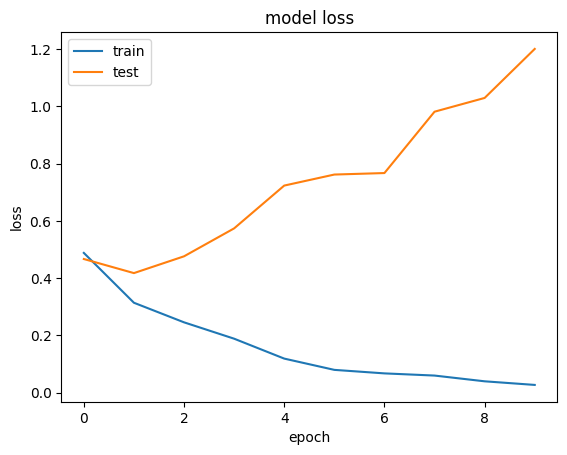

In [ ]:
plt.plot(history_BiLstm_model.history['loss'])
plt.plot(history_BiLstm_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
GRU_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length =max_len),
    GRU(hidden_size),
    Dense(1, activation = 'sigmoid')
])

GRU_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          3000000   
                                                                 
 gru_1 (GRU)                 (None, 256)               428544    
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,428,801
Trainable params: 3,428,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
GRU_model.compile(loss = 'binary_crossentropy',
                         optimizer = 'adam',
                         metrics = ['acc'])

save_model(GRU_model, './save_mode/GRU_model.h5')
history_GRU_model = GRU_model.fit(train_padded_sequences, train_labels,
                          validation_data = (test_padded_sequences, test_labels), epochs = 10, batch_size = 256)

Epoch 1/10
98/98 [==============================] - 21s 187ms/step - loss: 0.6296 - acc: 0.6180 - val_loss: 0.4811 - val_acc: 0.7821
Epoch 2/10
98/98 [==============================] - 13s 127ms/step - loss: 0.3602 - acc: 0.8482 - val_loss: 0.4381 - val_acc: 0.8114
Epoch 3/10
98/98 [==============================] - 10s 99ms/step - loss: 0.2689 - acc: 0.8958 - val_loss: 0.4553 - val_acc: 0.7999
Epoch 4/10
98/98 [==============================] - 8s 84ms/step - loss: 0.1997 - acc: 0.9269 - val_loss: 0.4974 - val_acc: 0.7966
Epoch 5/10
98/98 [==============================] - 7s 67ms/step - loss: 0.1461 - acc: 0.9502 - val_loss: 0.6656 - val_acc: 0.7983
Epoch 6/10
98/98 [==============================] - 8s 79ms/step - loss: 0.0957 - acc: 0.9688 - val_loss: 0.7317 - val_acc: 0.7824
Epoch 7/10
98/98 [==============================] - 6s 57ms/step - loss: 0.0655 - acc: 0.9786 - val_loss: 0.9038 - val_acc: 0.7881
Epoch 8/10
98/98 [==============================] - 6s 57ms/step - loss: 0.040

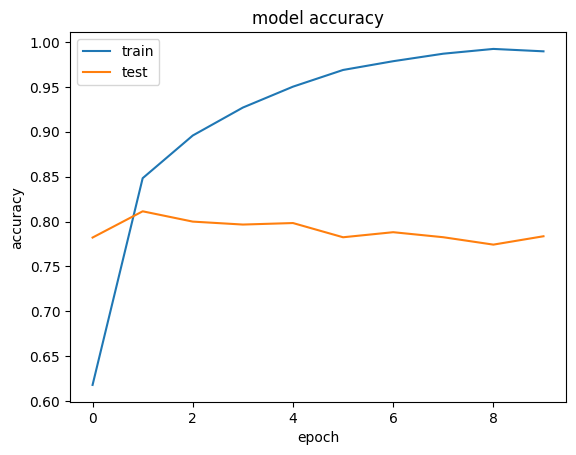

In [ ]:
plt.plot(history_GRU_model.history['acc'])
plt.plot(history_GRU_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

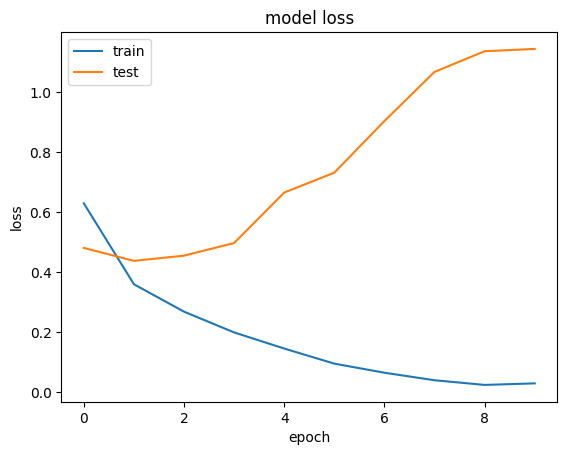

In [ ]:
plt.plot(history_GRU_model.history['loss'])
plt.plot(history_GRU_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
BiGRU_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length =max_len),
    GRU(hidden_size, return_sequences = True),
    Bidirectional(GRU(hidden_size)),
    Dense(1, activation = 'sigmoid')
])
BiGRU_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 300)          3000000   
                                                                 
 gru_2 (GRU)                 (None, 100, 256)          428544    
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              789504    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,218,561
Trainable params: 4,218,561
Non-trainable params: 0
_________________________________________________________________


In [ ]:
BiGRU_model.compile(loss = 'binary_crossentropy',
                         optimizer = 'adam',
                         metrics = ['acc'])

save_model(BiGRU_model, './save_mode/BiGRU_model.h5')
history_BiGRU_model = BiGRU_model.fit(train_padded_sequences, train_labels,
                          validation_data = (test_padded_sequences, test_labels), epochs = 10, batch_size = 256)

Epoch 1/10
98/98 [==============================] - 30s 246ms/step - loss: 0.5605 - acc: 0.6964 - val_loss: 0.4316 - val_acc: 0.8008
Epoch 2/10
98/98 [==============================] - 18s 186ms/step - loss: 0.3319 - acc: 0.8612 - val_loss: 0.4309 - val_acc: 0.8082
Epoch 3/10
98/98 [==============================] - 18s 186ms/step - loss: 0.2456 - acc: 0.9037 - val_loss: 0.4864 - val_acc: 0.7970
Epoch 4/10
98/98 [==============================] - 17s 170ms/step - loss: 0.1807 - acc: 0.9325 - val_loss: 0.5705 - val_acc: 0.7904
Epoch 5/10
98/98 [==============================] - 15s 156ms/step - loss: 0.1249 - acc: 0.9557 - val_loss: 0.7024 - val_acc: 0.7834
Epoch 6/10
98/98 [==============================] - 13s 133ms/step - loss: 0.0753 - acc: 0.9728 - val_loss: 0.8642 - val_acc: 0.7801
Epoch 7/10
98/98 [==============================] - 14s 148ms/step - loss: 0.0623 - acc: 0.9772 - val_loss: 1.0190 - val_acc: 0.7767
Epoch 8/10
98/98 [==============================] - 14s 144ms/step - 

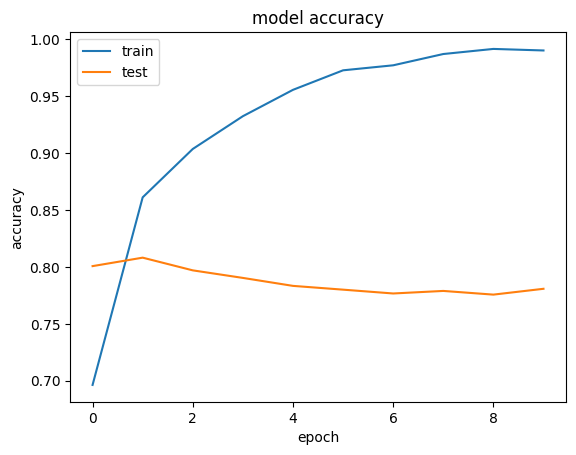

In [ ]:
plt.plot(history_BiGRU_model.history['acc'])
plt.plot(history_BiGRU_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

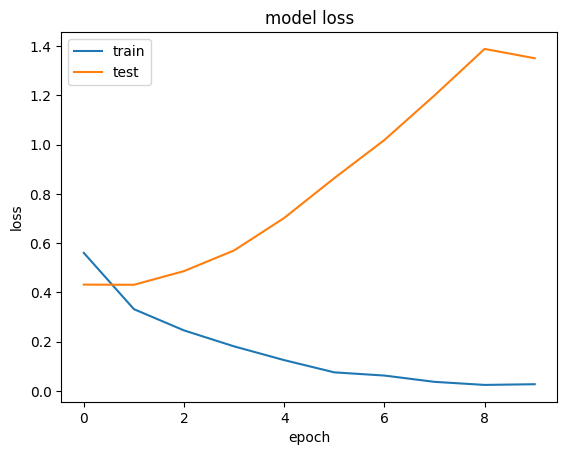

In [ ]:
plt.plot(history_BiGRU_model.history['loss'])
plt.plot(history_BiGRU_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [ ]:
BiLstm_customer = Sequential([
    Embedding(vocab_size, embedding_dim, input_length =max_len),
    LSTM(hidden_size, return_sequences = True),
    BatchNormalization(),
    Bidirectional(LSTM(hidden_size)),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
])
BiLstm_customer.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 300)          3000000   
                                                                 
 lstm_5 (LSTM)               (None, 100, 256)          570368    
                                                                 
 batch_normalization_2 (Batc  (None, 100, 256)         1024      
 hNormalization)                                                 
                                                                 
 bidirectional_5 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                      

In [ ]:
BiLstm_customer.compile(loss = 'binary_crossentropy',
                         optimizer = 'adam',
                         metrics = ['acc'])

save_model(BiLstm_customer, './save_mode/BiLstm_customer.h5')
history_BiLstm_customer = BiLstm_customer.fit(train_padded_sequences, train_labels,
                          validation_data = (test_padded_sequences, test_labels), epochs = 10, batch_size = 256)

Epoch 1/10
98/98 [==============================] - 33s 242ms/step - loss: 0.5316 - acc: 0.7490 - val_loss: 0.6135 - val_acc: 0.6921
Epoch 2/10
98/98 [==============================] - 19s 198ms/step - loss: 0.2803 - acc: 0.8839 - val_loss: 0.6324 - val_acc: 0.6270
Epoch 3/10
98/98 [==============================] - 18s 189ms/step - loss: 0.1667 - acc: 0.9358 - val_loss: 0.5442 - val_acc: 0.7504
Epoch 4/10
98/98 [==============================] - 16s 168ms/step - loss: 0.0942 - acc: 0.9654 - val_loss: 0.5870 - val_acc: 0.7770
Epoch 5/10
98/98 [==============================] - 17s 171ms/step - loss: 0.0598 - acc: 0.9784 - val_loss: 0.8344 - val_acc: 0.7581
Epoch 6/10
98/98 [==============================] - 17s 177ms/step - loss: 0.0497 - acc: 0.9828 - val_loss: 1.0124 - val_acc: 0.7866
Epoch 7/10
98/98 [==============================] - 17s 171ms/step - loss: 0.0347 - acc: 0.9883 - val_loss: 1.4444 - val_acc: 0.7680
Epoch 8/10
98/98 [==============================] - 14s 148ms/step - 

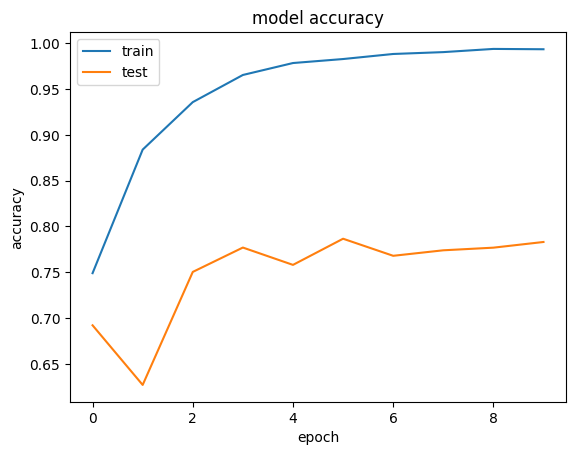

In [ ]:
plt.plot(history_BiLstm_customer.history['acc'])
plt.plot(history_BiLstm_customer.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

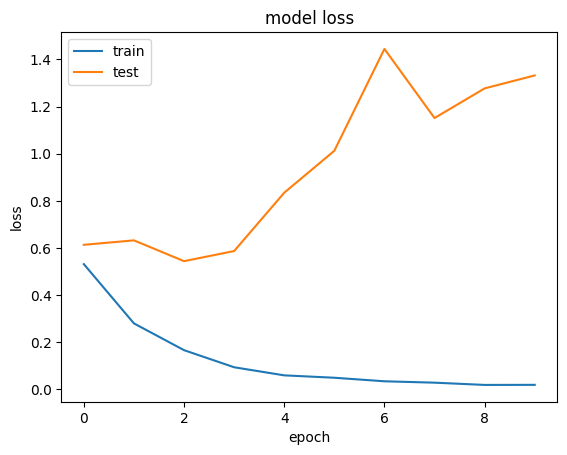

In [ ]:
plt.plot(history_BiLstm_customer.history['loss'])
plt.plot(history_BiLstm_customer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

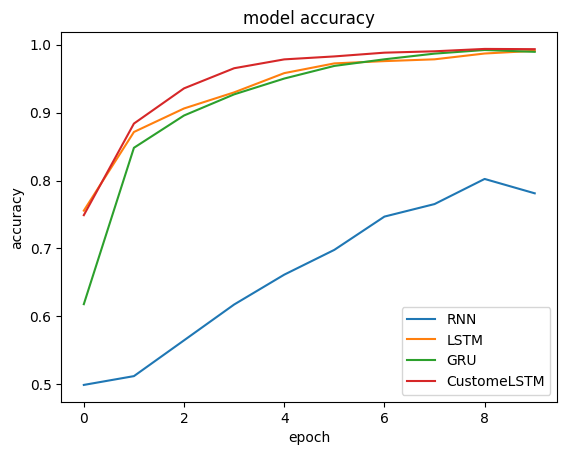

In [ ]:
plt.plot(history_simple_rnn.history['accuracy'])

plt.plot(history_BiLstm_model.history['acc'])

plt.plot(history_GRU_model.history['acc'])
plt.plot(history_BiLstm_customer.history['acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['RNN','LSTM','GRU', "CustomeLSTM"], loc = 'lower right')
plt.show()

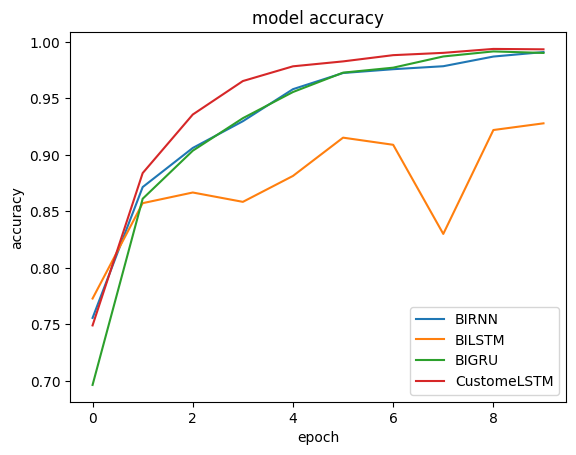

In [ ]:
plt.plot(history_BiLstm_model.history['acc'])

plt.plot(history_Lstm_model.history['acc'])

plt.plot(history_BiGRU_model.history['acc'])
plt.plot(history_BiLstm_customer.history['acc'])

plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['BIRNN','BILSTM','BIGRU',"CustomeLSTM"], loc = 'lower right')
plt.show()

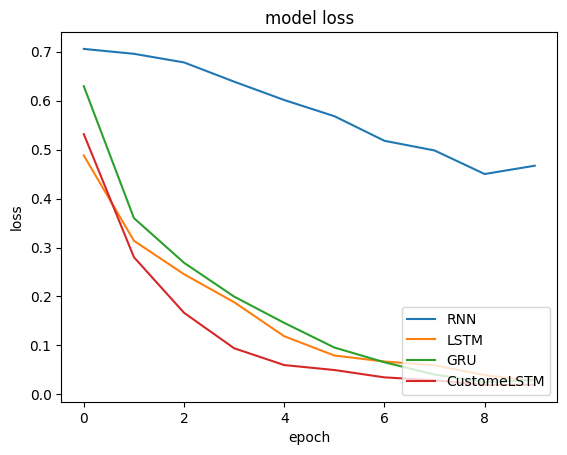

In [ ]:
plt.plot(history_simple_rnn.history['loss'])

plt.plot(history_BiLstm_model.history['loss'])

plt.plot(history_GRU_model.history['loss'])
plt.plot(history_BiLstm_customer.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['RNN','LSTM','GRU',"CustomeLSTM"], loc = 'lower right')
plt.show()

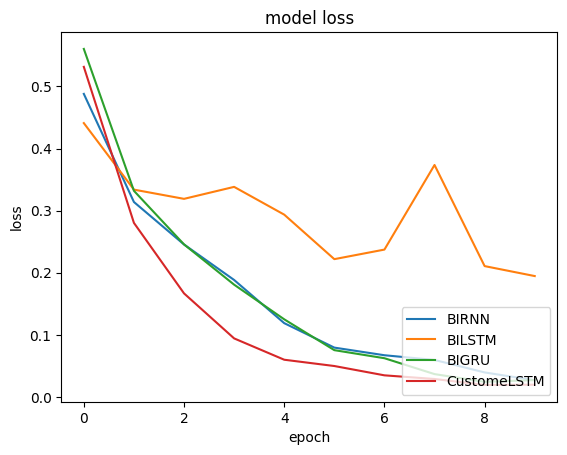

In [ ]:
plt.plot(history_BiLstm_model.history['loss'])

plt.plot(history_Lstm_model.history['loss'])

plt.plot(history_BiGRU_model.history['loss'])
plt.plot(history_BiLstm_customer.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['BIRNN','BILSTM','BIGRU',"CustomeLSTM"], loc = 'lower right')
plt.show()